In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:

# Description:
#   Exercise12 notebook.
#
# Copyright (C) 2018 Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.

# Preparations
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Select data directory
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('../data'):
    course_data_dir = '../data'
else:
    # Specify course_data_dir on your machine
    course_data_dir = r'C:\Users\70972\Desktop\Aalto\Computer Vision\exercise-12'

print('The data directory is %s' % course_data_dir)
data_dir = os.path.join(course_data_dir, 'exercise-12-data')
print('Data stored in %s' % data_dir)

The data directory is C:\Users\70972\Desktop\Aalto\Computer Vision\exercise-12
Data stored in C:\Users\70972\Desktop\Aalto\Computer Vision\exercise-12\exercise-12-data


Fill your name and student number below.

### Name: Yangzhe Kong
### Student number: 765756

# CS-E4850 Computer Vision Exercise Round 12

The problems should be solved before the exercise session and solutions returned via
MyCourses. Upload to MyCourses both: this Jupyter Notebook (.ipynb) file containing your solutions to the programming tasks and the exported pdf version of this Notebook file. If there are both programming and pen & paper tasks kindly combine the two pdf files (your scanned/LaTeX solutions and the exported Notebook) into a single pdf and submit that with the Notebook (.ipynb) file. <br><br> Note that (1) you are not supposed to change anything in the utils.py and (2) you should be sure that everything that you need to implement should work with the pictures specified by the assignments of this exercise round.

### Make sure to complete the pen and paper exercices in the PDF attached.

## Fundamental matrix estimation.

a)
Implement the eight-point algorithm as explained on slide 28 of Lecture 11. Note the skeleton function and follow the input output structure

b)
Implement the normalized eight-point algorithm as explained on slide 31 of Lecture 11 (Algorithm 11.1. in Hartley & Zisserman).

The epipolar lines obtained with both F-matrix estimates should be close to those visualized
by the example script.

In [4]:
def estimateF(x1,x2):
    # Return the fundamental matrix F (3 by 3), based on two sets of homogeneous 2D points x1 and x2.
    # Input: x1,x2 numpy ndarray (3 by N) containing matching 2D homogeneous points.
    # Output: F numpy ndarray (3 by 3) containing the fundamental matrix.
    n = x1.shape[1]  
    A = np.zeros((n,9))
    for i in range(n):
        u,v,u_,v_ = x1[0,i]/x1[2,i],x1[1,i]/x1[2,i],x2[0,i]/x2[2,i],x2[1,i]/x2[2,i]  
        A[i] = [u_*u,u_*v,u_,v_*u,v_*v,v_,u,v,1]
    # compute linear least square solution
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
    # rank 2 constrain on F
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = (U*S)@V
    return F

def estimateFnorm(x1,x2):
    # Return the fundamental matrix F (3 by 3), based on two sets of homogeneous 2D points x1 and x2.
    # Input: x1,x2 numpy ndarray (3 by N) containing matching 2D homogeneous points.
    # Output: F numpy ndarray (3 by 3) containing the fundamental matrix based on normalized homogeneous points.
    n = x1.shape[1]

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    s1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[s1,0,-s1*mean_1[0]],[0,s1,-s1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    s2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[s2,0,-s2*mean_2[0]],[0,s2,-s2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = estimateF(x1,x2)

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))
    return F
 
def vgg_F_from_P(P1,P2):
    # Return the fundamental matrix F (3 by 3), based on two camera parameter arrays.
    # Input: P1, P2 numpy ndarray (3 by 4) containing intrinsic and extrinsic parameters.
    # Output: F numpy ndarray (3 by 3) containing the fundamental matrix.
    X=[]
    Y=[]
    X.append(P1[[1,2],:])
    X.append(P1[[2,0],:])
    X.append(P1[[0,1],:])
    Y.append(P2[[1,2],:])
    Y.append(P2[[2,0],:])
    Y.append(P2[[0,1],:])
    F=np.zeros([3,3])
    
    for i in range(3):
        for j in range(3):
            M=np.concatenate([X[j],Y[i]])
            F[i,j]=np.linalg.det(M)
    return F

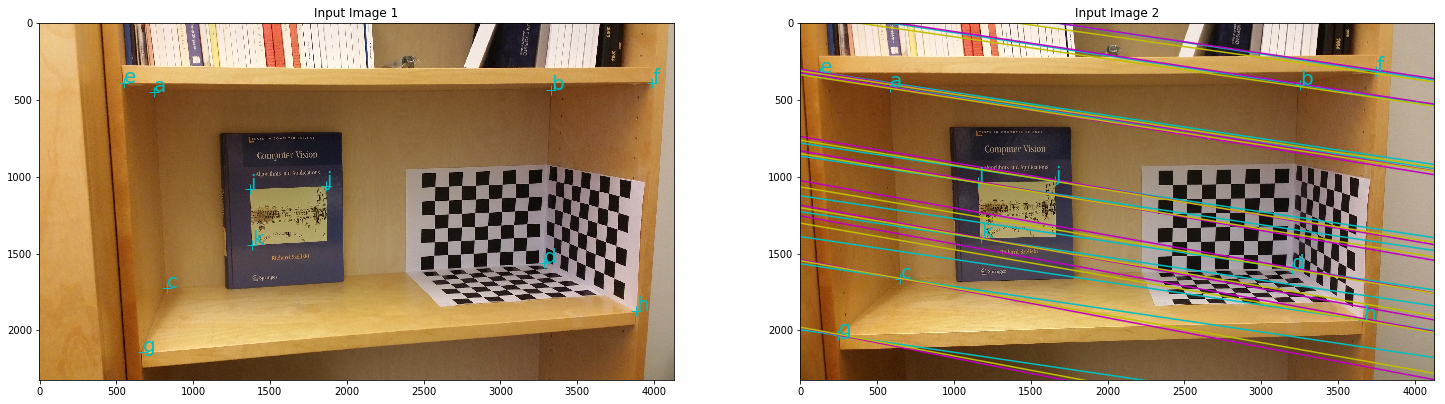

In [5]:
# Point locations
x1 = 1.0e+03*np.array([0.7435,3.3315,0.8275,3.2835,0.5475,3.9875,0.6715,3.8835,1.3715,1.8675,1.3835])
y1 = 1.0e+03*np.array([0.4455,0.4335,1.7215,1.5615,0.3895,0.3895,2.1415,1.8735,1.0775,1.0575,1.4415])
x2 = 1.0e+03*np.array([0.5835,3.2515,0.6515,3.1995,0.1275,3.7475,0.2475,3.6635,1.1555,1.6595,1.1755])
y2 = 1.0e+03*np.array([0.4135,0.4015,1.6655,1.5975,0.3215,0.3135,2.0295,1.9335,1.0335,1.0255,1.3975])

# Camera parameters
P1= np.row_stack([[-0.001162918366053,0.000102986385133,-0.000344703214391,0.995200644722518],\
                 [-0.000019974831639,0.001106889654747,-0.000150591916681,0.097841118173777],\
                 [-0.000000053632777,0.000000044849673,-0.000000270734766,0.000249501614496]])

P2= np.row_stack([[-0.001272880601540, 0.000093061493378,-0.000574486218854, 0.996457618133488],\
                 [-0.000002971652037, 0.001271207503106,-0.000200323351541, 0.084074548573989],\
                 [-0.000000020226464, 0.000000043518811,-0.000000316928290, 0.000265554210072]])

# Make homogenous representations of points
pts1=np.row_stack([x1,y1,np.ones_like(x1)])
pts2=np.row_stack([x2,y2,np.ones_like(x2)])

# Read images
# Read images
im1 = cv2.imread(data_dir+'/im1.jpg')
im2 = cv2.imread(data_dir+'/im2.jpg')

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)


# Labels
labels = ['a','b','c','d','e','f','g','h','i','j','k']

# Create figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
ax = axes.ravel()
ax[0].imshow(im1)
ax[0].plot(x1, y1, 'c+', markersize=10)

# Put labels
for i in range(len(x1)):    
    ax[0].annotate(labels[i], (x1[i], y1[i]), color='c', fontsize=20)
ax[0].set_title("Input Image 1")
ax[1].imshow(im2)
ax[1].plot(x2, y2, 'c+', markersize=10)
for i in range(len(x2)):    
    ax[1].annotate(labels[i], (x2[i], y2[i]), color='c', fontsize=20)
ax[1].set_title("Input Image 2")

# Get ground truth fundamental matrix
F=vgg_F_from_P(P1,P2)

# Create lines
#eplinesA=F@pts1
#eplinesB=F@pts2
eplinesA=np.dot(F,pts1)
eplinesB=np.dot(F,pts2)

#  Plot lines
px=np.array([0,np.shape(im2)[1]])
for i in range(np.shape(pts1)[1]):
    py=(-eplinesA[0,i]*px-eplinesA[2,i])/eplinesA[1,i]
    ax[1].plot(px,py,'c-');

# Get fundamental matrix and draw epipolar lines
F=estimateF(pts1,pts2)
#eplinesA=F@pts1
#eplinesB=F@pts2
eplinesA=np.dot(F,pts1)
eplinesB=np.dot(F,pts2)
for i in range(np.shape(pts1)[1]):
    py=(-eplinesA[0,i]*px-eplinesA[2,i])/eplinesA[1,i]
    ax[1].plot(px,py,'m-');

# Get fundamental matrix from normalized algorithm and draw epipolar lines
F=estimateFnorm(pts1,pts2)
#eplinesA=F@pts1
#eplinesB=F@pts2
eplinesA=np.dot(F,pts1)
eplinesB=np.dot(F,pts2)
for i in range(np.shape(pts1)[1]):
    py=(-eplinesA[0,i]*px-eplinesA[2,i])/eplinesA[1,i]
    ax[1].plot(px,py,'y-');

ax[1].axes.set_xlim([0,np.shape(im2)[1]])
ax[1].axes.set_ylim([np.shape(im2)[0],0])
plt.show()

## Demo. Stereo disparity computation. (Just a demo, no points given)
Run and study the opencv stereo disparity and depth estimation.

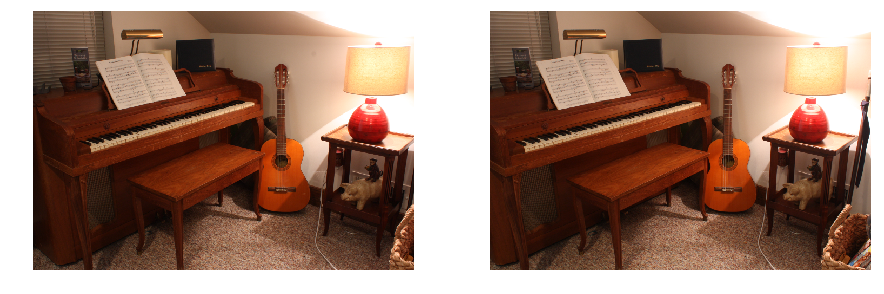

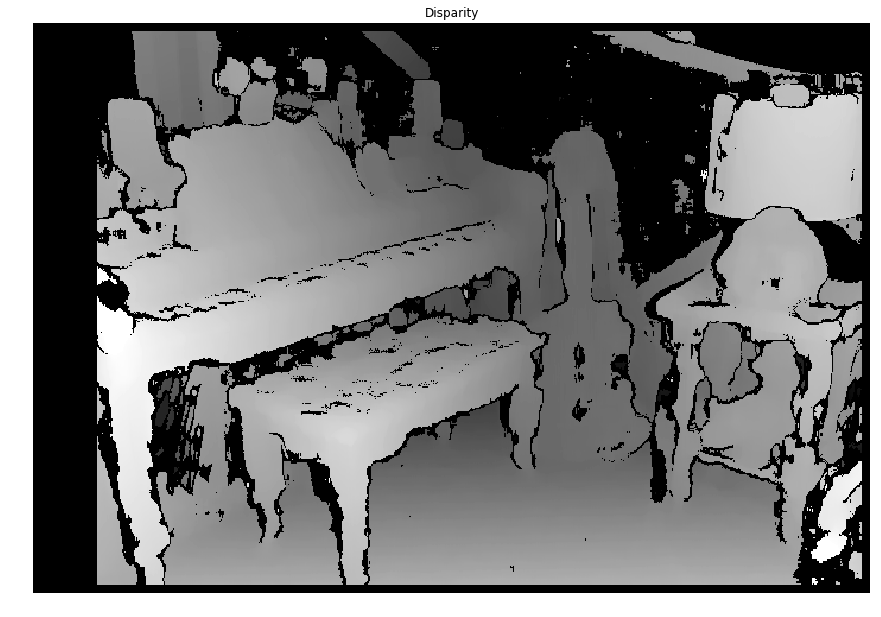

In [6]:
# Import images
sc=0.25

imgL = cv2.resize(cv2.imread(data_dir+'/im0.png',0), (0,0), fx=sc, fy=sc)
imgR = cv2.resize(cv2.imread(data_dir+'/im1.png',0), (0,0), fx=sc, fy=sc) 
imgL_col = cv2.resize(cv2.imread(data_dir+'/im0.png'), (0,0), fx=sc, fy=sc) 
imgR_col = cv2.resize(cv2.imread(data_dir+'/im1.png'), (0,0), fx=sc, fy=sc) 

# Show images
plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(imgL_col[:,:,[2,1,0]])
plt.axis('off')
plt.subplot(122)
plt.imshow(imgR_col[:,:,[2,1,0]])
plt.axis('off')

# Compute disparity
stereo = cv2.StereoBM_create(numDisparities=16*3, blockSize=15)
disparity = stereo.compute(imgL,imgR)

# Show disparity
plt.figure(figsize=[15,15])
plt.imshow(disparity,'gray')
plt.axis('off')
plt.title('Disparity')
#ndistp=cv2.guidedFilter(imgL, disparity, 9, 4,0.1)

# Calibration data
baseline=17.8089 #cm 
f_length=2826.171*sc #pixels
c_point=np.array([1415.97,965.806])*sc # pixels

# Get depth from disparity
point=np.zeros([np.count_nonzero(disparity>1),6])
ind=0
for i in range(np.shape(disparity)[0]):
    for j in range(np.shape(disparity)[1]):
        if disparity[i,j]>1:
            # Save point information into point cloud
            # [pixel_x,pixel_y,disparity,color]
            point[ind,0:3]=j,i,disparity[i,j]
            point[ind,3:6]=imgL_col[i,j]/255.0
            ind+=1
# Z=baseline*focal/disparity
# openCV disparity is (16*actual_disparity). This depends on the algorithm.
# It is in order to use signed shorts and keep good subpixel accuracy.
point[:,2]=baseline*f_length/(point[:,2]/16.0)
#X=Z*(pixel_u-center_u)/focal
point[:,0]=point[:,2]*(point[:,0]-c_point[0])/f_length
#Y=Z*(pixel_v-center_v)/focal
point[:,1]=-point[:,2]*(point[:,1]-c_point[1])/f_length

# Delete points on the far background
inl=(point[:,2]<2000)
point=point[inl,:]

plt.show()


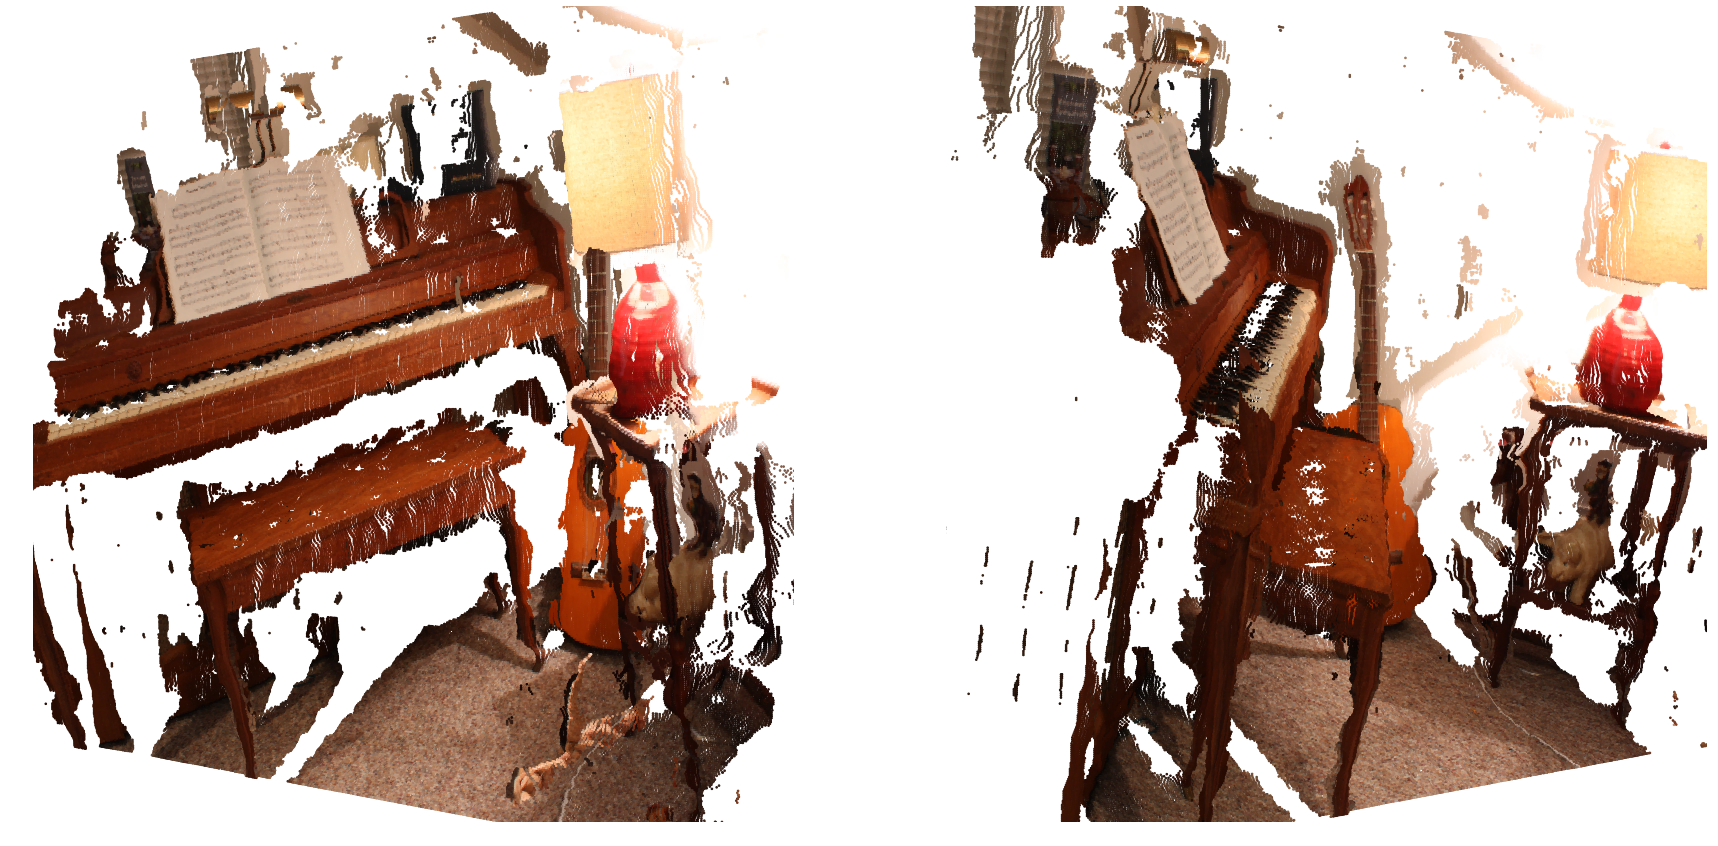

In [7]:
def visualize_points(pts,R,img,f=1000,cp=[400,300]):
    #visualize colored points given a rotation matrix    
    # rotate around the mean of the point cloud
    c=np.mean(point[:,0:3],0)
    #r_point=((point[:,0:3]-c)@R_y)+c
    r_point=np.dot((point[:,0:3]-c),R_y)+c

    #Project back to the same camera model
    K=np.float32([[f,0,cp[0]],[0,f,cp[1]],[0,0,1]])

    # Sort by depth (painter's algorithm)
    ind=np.argsort(r_point[:,2])
    r_point=r_point[np.flip(ind,0),:]

    #Project
    #uvk=K@r_point.T
    uvk=(np.dot(K,r_point.T))
    color=point[:,[5,4,3]]
    color=color[np.flip(ind,0),:]

    # Normalize homogeneous  coordinates
    uv=uvk[0:2,:]/(uvk[2,:])

    # Draw projected points
    plt.scatter(uv[0,:],uv[1,:],marker='.',s=10,c=color)
    plt.xlim([0,np.shape(imgL)[1]])
    plt.ylim([0,np.shape(imgL)[0]])
    plt.axis('off')
    
    
    
# Visualize points from two different angles
plt.figure(figsize=[30,15])
plt.subplot(121)
# Rotate around y axis to visualize
ang_y=-20.0
ang_y=ang_y/180.0*3.14
R_y=np.float32([[np.cos(ang_y),0,np.sin(ang_y)],[0,1,0],[-np.sin(ang_y),0,np.cos(ang_y)]])
visualize_points(point,R_y,imgL,f_length,c_point)
plt.subplot(122)
# Rotate around y axis to visualize
ang_y=20.0
ang_y=ang_y/180.0*3.14
R_y=np.float32([[np.cos(ang_y),0,np.sin(ang_y)],[0,1,0],[-np.sin(ang_y),0,np.cos(ang_y)]])
visualize_points(point,R_y,imgL,f_length,c_point)
plt.show()